# Trabajo final LC POS-Tagging. Curso 2020-2021
### Jaime Ferrando Huertas
### Javier Martínez Bernia

## Preparamos los datos

In [11]:
#IMPORTS
import nltk
from nltk.corpus import cess_esp
from nltk.tag import UnigramTagger,BigramTagger,hmm, tnt, AffixTagger,brill, brill_trainer, crf, perceptron
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from random import shuffle

nltk.download('cess_esp')

[nltk_data] Downloading package cess_esp to /home/javi/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


True

In [12]:
#Cargamos el corpus

corpus = list(cess_esp.tagged_sents())
number_sentences = len(corpus)
print("number of sentnces:", number_sentences)
print("number of words:", number_sentences)


number of sentnces: 6030
number of words: 6030


In [13]:
#Procesamos el corpus
processed_corpus = []
for sentence in corpus:
    tmp_sentence = []
    for word in sentence:
        if word[0] == "*0*":
            continue
        if word[1][0] == "v" or "F":
            new_word = (word[0], word[1][:3])
        else:
            new_word = (palabra_etiquetada[0], word[1][:2])
        tmp_sentence.append(new_word)
    processed_corpus.append(tmp_sentence)

In [14]:
# Shuffle data
shuffle(corpus)
shuffle(processed_corpus)

# Tarea 1 

En esta tarea realizaremos una evaluación del etiquetador 'hmm' sobre el corpus 'cess-esp' mediante validación cruzada en 10 bloques. Antes de particionar el corpus, lo barajaremos.

In [7]:
%%time
results_hmm_unprocessed = []
intervals_hmm_unprocessed = []
kf_fold = KFold(n_splits=10, shuffle=False)
for train_index, test_index in kf_fold.split(corpus):
    #Split data
    training_cv = np.take(corpus,train_index)
    test_cv = np.take(corpus,test_index)
    
    #HMM
    tagger_hmm = hmm.HiddenMarkovModelTagger.train(training_cv)
    v = tagger_hmm.evaluate(test_cv)
    results_hmm_unprocessed.append(v)
    #Number of words on test partition
    N = 0
    for i in test_cv: N += len(i)
    #Intervalos
    d = 1.96*math.sqrt((v*(1-v))/N)
    ic = round(d,3)
    intervals_hmm_unprocessed.append(ic)

results_hmm_processed = []
intervals_hmm_processed = []
kf_fold = KFold(n_splits=10, shuffle=False)
for train_index, test_index in kf_fold.split(processed_corpus):
    #Split data
    #training_cv = [corpus[i] for i in train_index]
    #test_cv = [corpus[i] for i in test_index]
    training_cv = np.take(processed_corpus,train_index)
    test_cv = np.take(processed_corpus,test_index)
    #HMM
    tagger_hmm = hmm.HiddenMarkovModelTagger.train(training_cv)
    v = tagger_hmm.evaluate(test_cv)
    results_hmm_processed.append(v)
    #Number of words on test partition
    N = 0
    for i in test_cv: N += len(i)
    #Intervalos
    d = 1.96*math.sqrt((v*(1-v))/N)
    ic = round(d,3)
    intervals_hmm_processed.append(ic)
    
print("Accuracy sin procesar:", sum(results_hmm_unprocessed)/len(results_hmm_unprocessed))
print("Accuracy procesando: " , sum(results_hmm_processed)/len(results_hmm_processed))


Accuracy sin procesar: 0.8964994921675549
Accuracy procesando:  0.9162786012262746
CPU times: user 8min 28s, sys: 501 ms, total: 8min 29s
Wall time: 8min 29s


| Corpus | Accuracy |
| --- | --- |
| Sin procesar | 0.896500 |
| Procesado | 0.916279 |

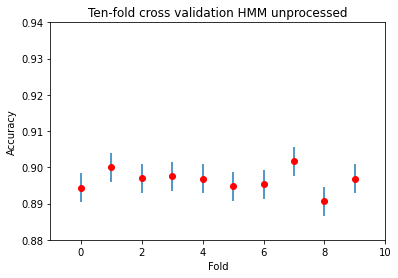

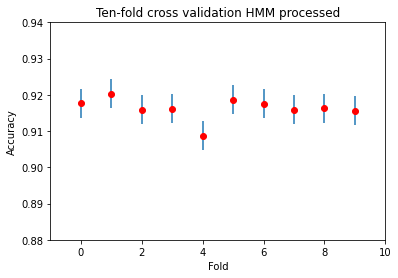

In [9]:
x=[i for i in range(10)]
y=results_hmm_unprocessed # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.88, 0.94])
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title('Ten-fold cross validation HMM unprocessed')
plt.plot(x,y,'ro')
Tic=intervals_hmm_unprocessed# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.show()

x=[i for i in range(10)]
y=results_hmm_processed # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.88, 0.94])
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title('Ten-fold cross validation HMM processed')
plt.plot(x,y,'ro')
Tic=intervals_hmm_processed# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.show()

# Tarea 2

En esta tarea se evaluará el etiquetador ’hmm’ variando el tamano del corpus de aprendizaje.
En cada  ejecución, se irá incrementando sucesivamente el tamaño del corpus de entrenamiento, manteniendo fija la partición de test.

In [13]:
%%time
results_hmm_train_limited = []
intervals_hmm_train_limited = []
for i in np.arange(0.1, 1.0, 0.1): #We iterate a list array([0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9])
    #Split data
    len_training = int(i*len(processed_corpus))
    training_notcv = processed_corpus[:len_training]
    test_notcv = processed_corpus[int(0.9*len(processed_corpus)):]
    #HMM
    tagger_hmm = hmm.HiddenMarkovModelTagger.train(training_notcv)
    v = tagger_hmm.evaluate(test_notcv)
    results_hmm_train_limited.append(v)
    #Number of words on test partition
    N = 0
    for i in test_notcv: N += len(i)
    #Intervalos
    d = 1.96*math.sqrt((v*(1-v))/N)
    ic = round(d,3)
    intervals_hmm_train_limited.append(ic)
    
print("Resultados incrementales:", results_hmm_train_limited)

Resultados incrementales: [0.8308326463314097, 0.8670513877438857, 0.8841989557570761, 0.8959604286892003, 0.9048090134652377, 0.9112393514701841, 0.9171200879362462, 0.9205825776312173, 0.923605386095081]
CPU times: user 1min 14s, sys: 251 ms, total: 1min 15s
Wall time: 1min 15s


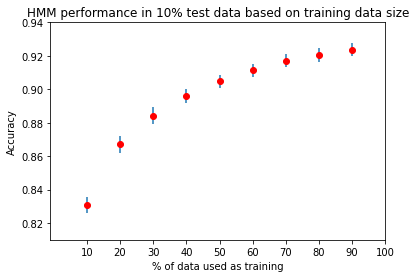

In [19]:
xticks = np.arange(10, 110, step=10)
x=xticks[:9]
y=results_hmm_train_limited # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.81, 0.94])
plt.xticks(xticks)
plt.ylabel('Accuracy')
plt.xlabel('% of data used as training')
plt.title('HMM performance in 10% test data based on training data size')
plt.plot(x,y,'ro')
Tic=intervals_hmm_train_limited# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.savefig('task2.png')
plt.show()

# Tarea 3

In [59]:
def tr_te_tnt_smooth(tr,te,n):
    # n: longitud del sufijo
    # Entrenamos y evaluamos el tagger tnt con suavizado utilizando
    # AffixTagger como etiquetador para las palabras desconocidas
    
    # Inicializamos y entrenamos AffixTagger
    sufix_tagger = AffixTagger(tr, affix_length=-n)
    # Inicializamos TnT pasando el tagger anterior como parámetro
    tnt_tagger = tnt.TnT(unk = sufix_tagger, Trained = True)
    # Entrenamos TnT
    tnt_tagger.train(tr)
    # Evaluamos con te
    return tnt_tagger.evaluate(te)

In [27]:
%%time
# Entrenamos el Affix Tagger para distinta longitud de sufijo

from nltk.tag import AffixTagger
kf_fold = KFold(n_splits=10, shuffle=False)
results_affix_processed = [] # Global results of each 10-fold
intervals_affix_processed = [] # Global intervals of each 10-fold
for n in range(-10,0):
    tmp_results = []
    for train_index, test_index in kf_fold.split(processed_corpus):
        #Split data
        training_cv = np.take(processed_corpus,train_index).tolist()
        test_cv = np.take(processed_corpus,test_index).tolist()
        #Affix Tagger
        sufix_tagger = AffixTagger(training_cv,affix_length=-n)
        v = sufix_tagger.evaluate(test_cv)
        tmp_results.append(v)
        
    # Global result
    avg_results = sum(tmp_results)/len(tmp_results)
    results_affix_processed.append(avg_results)
    # Global interval
    tmp_global_ic = 0
    for i in range(10):
        tmp_global_ic += (tmp_results[i] - avg_results) **2
    tmp_global_ic = 1.96*math.sqrt(tmp_global_ic/len(tmp_results))
    intervals_affix_processed.append(tmp_global_ic)
    
    

CPU times: user 33.7 s, sys: 3.97 ms, total: 33.7 s
Wall time: 33.7 s


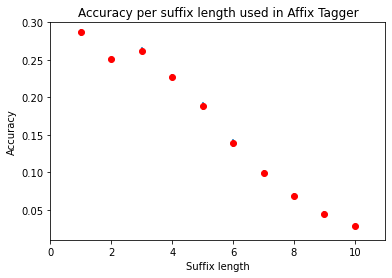

In [87]:
xticks = [-i for i in range(-10,0)]
x=xticks
y=results_affix_processed # results es una lista con los resultados de cada experimento
plt.axis([0, 11, 0.01, 0.30])
plt.ylabel('Accuracy')
plt.xlabel('Suffix length')
plt.title('Accuracy per suffix length used in Affix Tagger')
plt.plot(x,y,'ro')
Tic=intervals_affix_processed# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.savefig('acc_suffix_length.png')
plt.show()

Viendo la gráfica anterior escogemos una longitud de sufijo de 1 para entrenar tnt

In [34]:
%%time
# Train TNT without Smoothing
results_tnt_no_smooth = []
intervals_tnt_no_smooth = []
kf_fold = KFold(n_splits=10, shuffle=False)
for train_index, test_index in kf_fold.split(processed_corpus):
        #Split data
        training_cv = np.take(processed_corpus,train_index).tolist()
        test_cv = np.take(processed_corpus,test_index).tolist()
        # TNT without Smoothing
        tnt_tagger = tnt.TnT()
        tnt_tagger.train(training_cv)
        v = tnt_tagger.evaluate(test_cv) 
        results_tnt_no_smooth.append(v)
        #Number of words on test partition
        N = 0
        for i in test_notcv: N += len(i)
        #Intervalos
        d = 1.96*math.sqrt((v*(1-v))/N)
        ic = round(d,3)
        intervals_tnt_no_smooth.append(ic)
        

# Train TNT+Smoothing (suffix length = 1)
results_tnt_affix_length_2 = []
intervals_tnt_affix_length_2 = []
kf_fold = KFold(n_splits=10, shuffle=False)
for train_index, test_index in kf_fold.split(processed_corpus):
        #Split data
        training_cv = np.take(processed_corpus,train_index).tolist()
        test_cv = np.take(processed_corpus,test_index).tolist()
        # TNT + Smoothing
        v = tr_te_tnt_smooth(training_cv,test_cv,1)
        results_tnt_affix_length_2.append(v)
        #Number of words on test partition
        N = 0
        for i in test_notcv: N += len(i)
        #Intervalos
        d = 1.96*math.sqrt((v*(1-v))/N)
        ic = round(d,3)
        intervals_tnt_affix_length_2.append(ic)

CPU times: user 15min 49s, sys: 948 ms, total: 15min 50s
Wall time: 15min 51s


In [36]:
print("Accuracy TnT sin suavizado:", sum(results_tnt_no_smooth)/len(results_tnt_no_smooth))
print("Accuracy TnT con suavizado y sufijo longitud 1:", sum(results_tnt_affix_length_2)/len(results_tnt_affix_length_2))

Accuracy TnT sin suavizado: 0.9017950976738346
Accuracy TnT con suavizado y sufijo longitud 1: 0.9296972987350433


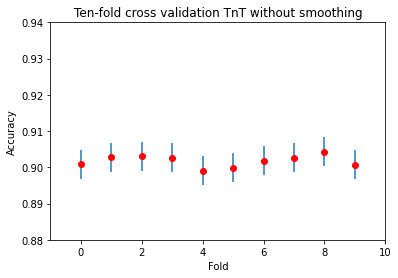

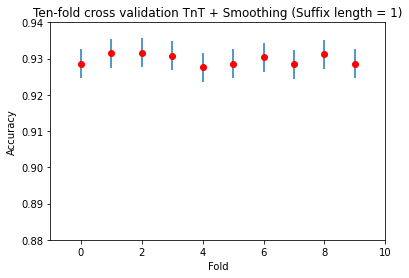

In [83]:
x=[i for i in range(10)]
y=results_tnt_no_smooth # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.88, 0.94])
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title('Ten-fold cross validation TnT without smoothing')
plt.plot(x,y,'ro')
Tic=intervals_tnt_no_smooth # Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.savefig('TnT_no_smooth.png')
plt.show()

x=[i for i in range(10)]
y=results_tnt_affix_length_2 # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.88, 0.94])
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title('Ten-fold cross validation TnT + Smoothing (Suffix length = 1)')
plt.plot(x,y,'ro')
Tic=intervals_tnt_affix_length_2 # Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.savefig('TnT_suffix_1.png')
plt.show()

In [7]:
%%time
# Entrenar TnT + suavizado con Affix Tagger para distinta longitud de sufijo (1:9)
from nltk import AffixTagger
results_tnt_affix_length = []
intervals_tnt_affix_length = []
for l in range(1, 10):
    kf_fold = KFold(n_splits=10, shuffle=False)
    for train_index, test_index in kf_fold.split(processed_corpus):
        #Split data
        training_cv = np.take(processed_corpus,train_index).tolist()
        test_cv = np.take(processed_corpus,test_index).tolist()
        # TNT + Smoothing
        v = tr_te_tnt_smooth(training_cv,test_cv,l)
        results_tnt_affix_length.append(v)
        #Number of words on test partition
        N = 0
        for i in test_cv: N += len(i)
        #Intervalos
        d = 1.96*math.sqrt((v*(1-v))/N)
        ic = round(d,3)
        intervals_tnt_affix_length.append(ic)

CPU times: user 1h 16min 39s, sys: 11.1 s, total: 1h 16min 50s
Wall time: 1h 17min


In [10]:
# Calcular los resultados medios y los intervalos de las 9 ejecuciones
r = []
intervals = []
done = False
i = 0
while (not done):
    avg_results = sum(results_tnt_affix_length[i:i+10])/10
    r.append(avg_results)
    
    # Intervals
    tmp_ic = 0
    for j in range(10):
        tmp_ic+= (results_tnt_affix_length[i+j] - avg_results) **2
    tmp_ic= 1.96*math.sqrt(tmp_ic/10)
    intervals.append(tmp_ic)    
    i += 10
    if (i == 90) : done = True

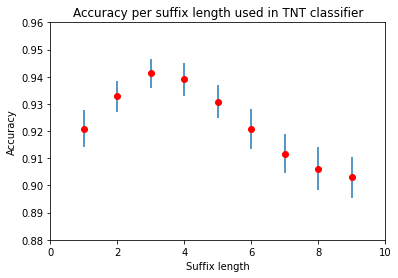

In [14]:
xticks = list(range(1,10))
x=xticks
y=r # results es una lista con los resultados de cada experimento
plt.axis([0, 10, 0.88, 0.96])
plt.ylabel('Accuracy')
plt.xlabel('Suffix length')
plt.title('Accuracy per suffix length used in TNT classifier')
plt.plot(x,y,'ro')
Tic=intervals # Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.savefig('tnt_smooth_all.png')
plt.show()

Como la mejor combinación es suavizado con sufijo de longitud 3 + TnT, evaluaremos esta combinación a continuación.

In [48]:
# Train TNT+Smoothing (suffix length = 3)
results_tnt_affix_length_3 = []
intervals_tnt_affix_length_3 = []
kf_fold = KFold(n_splits=10, shuffle=False)
for train_index, test_index in kf_fold.split(processed_corpus):
        #Split data
        training_cv = np.take(processed_corpus,train_index).tolist()
        test_cv = np.take(processed_corpus,test_index).tolist()
        # TNT + Smoothing
        v = tr_te_tnt_smooth(training_cv,test_cv,3)
        results_tnt_affix_length_3.append(v)
        #Number of words on test partition
        N = 0
        for i in test_notcv: N += len(i)
        #Intervalos
        d = 1.96*math.sqrt((v*(1-v))/N)
        ic = round(d,3)
        intervals_tnt_affix_length_3.append(ic)

In [88]:
print("Accuracy TnT con suavizado y sufijo longitud 1:", sum(results_tnt_affix_length_3)/len(results_tnt_affix_length_3))

Accuracy TnT con suavizado y sufijo longitud 1: 0.9472766524716605


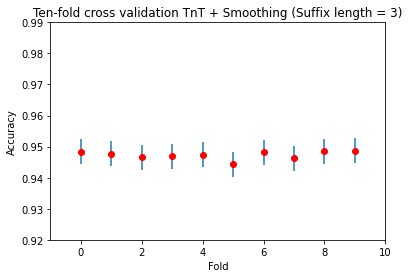

In [86]:
x=[i for i in range(10)]
y=results_tnt_affix_length_3 # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.92, 0.99])
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.title('Ten-fold cross validation TnT + Smoothing (Suffix length = 3)')
plt.plot(x,y,'ro')
Tic=intervals_tnt_affix_length_2 # Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.savefig('TnT_suffix_3.png')
plt.show()

# Tarea 4

In [60]:
# Division del corpus
train = processed_corpus[:int(0.9*len(processed_corpus))]
test = processed_corpus[int(0.9*len(processed_corpus)):]
N = 0
for i in test: N += len(i)

results = []
ics = []

## HMM

In [61]:
hmm_tagger = hmm.HiddenMarkovModelTagger.train(train)
acc = hmm_tagger.evaluate(test)
print("Accuracy of HMM Tagger : ", acc)
print('[',acc-1.96*math.sqrt((acc*(1-acc))/N),',',acc+1.96*math.sqrt((acc*(1-acc))/N),']')
results.append(acc)
ics.append(1.96*math.sqrt((acc*(1-acc))/N))

Accuracy of HMM Tagger :  0.9147977363236219
[ 0.9108366940740543 , 0.9187587785731895 ]


## TnT

In [62]:
tnt_tagger = tnt.TnT()
tnt_tagger.train(train)
acc = tnt_tagger.evaluate(test)
print ("Accuracy of TnT Tagger : ", acc)
print('[',acc-1.96*math.sqrt((acc*(1-acc))/N),',',acc+1.96*math.sqrt((acc*(1-acc))/N),']')
results.append(acc)
ics.append(1.96*math.sqrt((acc*(1-acc))/N))

Accuracy of TnT Tagger :  0.8965625654998952
[ 0.8922419010610805 , 0.90088322993871 ]


In [63]:
# TnT + Smoothing with Affix Tagger length 3
acc = tr_te_tnt_smooth(train,test,3)
print ("Accuracy of TnT + Smooth : ", acc)
print('[',acc-1.96*math.sqrt((acc*(1-acc))/N),',',acc+1.96*math.sqrt((acc*(1-acc))/N),']')
results.append(acc)
ics.append(1.96*math.sqrt((acc*(1-acc))/N))

Accuracy of TnT + Smooth :  0.9423076923076923
[ 0.9389996070708366 , 0.945615777544548 ]


## Brill

In [64]:
%%time
tagger_unigramas = UnigramTagger(train)
brill.Template._cleartemplates()
templates = brill.fntbl37()
trainer = nltk.tag.brill_trainer.BrillTaggerTrainer(initial_tagger=tagger_unigramas,
                                   templates=templates, trace=3,
                                   deterministic=True)
trainer._trace=0 #We hide the training loop prints
brill_trained = trainer.train(train, max_rules=1000)

CPU times: user 36.4 s, sys: 40 ms, total: 36.4 s
Wall time: 36.4 s


In [65]:
# Brill with unigramtagger
acc = brill_trained.evaluate(test)
print("Accuracy of Brill + UnigramTagger : ", acc)
print('[',acc-1.96*math.sqrt((acc*(1-acc))/N),',',acc+1.96*math.sqrt((acc*(1-acc))/N),']')
results.append(acc)
ics.append(1.96*math.sqrt((acc*(1-acc))/N))

Accuracy of Brill + UnigramTagger :  0.894938168098931
[ 0.8905876561353591 , 0.899288680062503 ]


In [66]:
tagger_unigramas = hmm.HiddenMarkovModelTagger.train(train)
brill.Template._cleartemplates()
templates = brill.fntbl37()
trainer = nltk.tag.brill_trainer.BrillTaggerTrainer(initial_tagger=tagger_unigramas,
                                   templates=templates, trace=3,
                                   deterministic=True)
trainer._trace=0 #We hide the training loop prints
brill_trained = trainer.train(train, max_rules=1000)

In [67]:
# Brill with hmmtagger
acc = brill_trained.evaluate(test)
print("Accuracy of Brill + HMM Tagger : ",acc)
print('[',acc-1.96*math.sqrt((acc*(1-acc))/N),',',acc+1.96*math.sqrt((acc*(1-acc))/N),']')
results.append(acc)
ics.append(1.96*math.sqrt((acc*(1-acc))/N))

Accuracy of Brill + HMM Tagger :  0.9179941312093901
[ 0.9141013160144833 , 0.9218869464042969 ]


## CRF

In [68]:
tagger_crf = crf.CRFTagger()
tagger_crf.train(train, "model")
acc = tagger_crf.evaluate(test)
print("Accuracy of CRF Tagger : ",acc)
print('[',acc-1.96*math.sqrt((acc*(1-acc))/N),',',acc+1.96*math.sqrt((acc*(1-acc))/N),']')
results.append(acc)
ics.append(1.96*math.sqrt((acc*(1-acc))/N))

Accuracy of CRF Tagger :  0.9487528819953888
[ 0.9456244073115795 , 0.951881356679198 ]


## Perceptron

In [69]:
tagger_perceptron = perceptron.PerceptronTagger(load = False)
tagger_perceptron.train(train)
acc = tagger_perceptron.evaluate(test)
print("Accuracy of Perceptron Tagger : ",acc)
print('[',acc-1.96*math.sqrt((acc*(1-acc))/N),',',acc+1.96*math.sqrt((acc*(1-acc))/N),']')
results.append(acc)
ics.append(1.96*math.sqrt((acc*(1-acc))/N))

Accuracy of Perceptron Tagger :  0.9615908614546217
[ 0.9588641837034253 , 0.9643175392058181 ]


<ipython-input-75-2b373caf0ae3>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


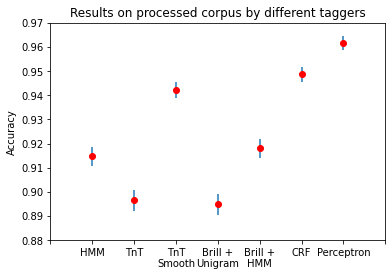

In [75]:
fig, ax = plt.subplots()
fig.canvas.draw()
x=[i for i in range(7)]
labels = ["","HMM", "TnT", "TnT\nSmooth", "Brill +\nUnigram", "Brill +\nHMM", "CRF", "Perceptron"]
ax.set_xticklabels(labels)
y=results # results es una lista con los resultados de cada experimento
plt.axis([-1, 7, 0.88, 0.97])
plt.ylabel('Accuracy')
plt.title('Results on processed corpus by different taggers')
plt.plot(x,y,'ro')
Tic=ics # Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.savefig('task4.png')
plt.show()